## networkMDE examples

### setup

In [1]:
import numpy as np 
import matplotlib.pyplot as plt # on which networkMDE.netplot module is based

import cnets # this is part of the networkMDE package
from networkMDE.network import dirNetwork, undNetwork
from networkMDE import netplot

# set the seeds for reproducibility
np.random.seed(42)
cnets.set_seed(42)

# wurlitzer is needed to show C stdout/stderr outputs from cnets
# (only in jupyter notebooks)
%load_ext wurlitzer

### Basic operations

A network is defined by an adjacence matrix or a link sparse matrix.

At the moment each node of the network can carry a scalar value and a set of links with given distance/weight.

Each link contains the node connected and optionally a scalar value called `activation`.

The simplest non-distortionless network in a 2D embedding is a tetragon.

In [2]:
# link sparse matrix is in format [node1, node2 , distance]
link_sparse_matrix = [  [0,1, 1.0],
                        [1,2, 1.0],
                        [2,0, 1.0],
                        [3,0, 0.8],
                        [3,1, 0.8],
                        [3,2, 0.8]]
tetragon = undNetwork.from_sparse(link_sparse_matrix)
tetragon.values = range(len(tetragon.nodes))

Network has 4 elements and 6 links (density =  100.0 %)


the embedding is then randomly initialized, links are respected but distorted. The distortion can be visualized by `distortion_activation()` mehod of network, which assign a monotonically increasing function of the distortion of each link as its activation.

*Blue* means that the link representation is *shorter* than it should be, while *red* means that the link is *longer* than it should be.

cnets - INFO: Generating network...	Done.
cnets - INFO: Random initialization in R2...	Done.
Plot started:
Getting graphics..	Done.
Updating scatter..	Done.
Updating lines..	Done.
Mean distortion is 0.57


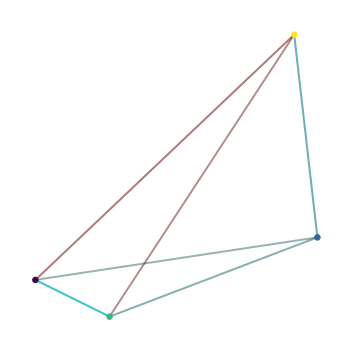

In [3]:
tetragon.initialize_embedding(dim=2)
tetragon.distortion_activation()

# plot with thicker lines
netplot.line_kwargs['lw'] = 2.0

netplot.plot_net(tetragon)
print(f"Mean distortion is {cnets.get_distortion():.2f}")

network.cMDE method minimizes the distortion of the embedding

cnets - INFO: starting MDE with eps = 0.500, neg_eps = 0.000, Nsteps = 1000
|▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒|98 % (D = 0.0565)KK
cnets - INFO: MDE end
Plot started:
Getting graphics..	Done.
Updating scatter..	Done.
Updating lines..	Done.
Mean distortion is 0.06


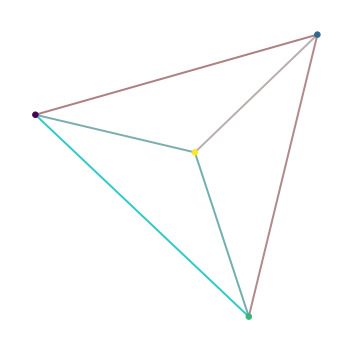

In [4]:
tetragon.cMDE(0.5, 0.0, 1000)
tetragon.distortion_activation()
netplot.plot_net(tetragon)
print(f"Mean distortion is {cnets.get_distortion():.2f}")

#### negative sampling

Minimizing distortion does not ensure that the graph is represented in a reasonable clear way. As an example consider the following simple graph

Network has 4 elements and 3 links (density =  50.0 %)
cnets - INFO: Generating network...	Done.
cnets - INFO: Random initialization in R2...	Done.
cnets - INFO: starting MDE with eps = 1.000, neg_eps = 0.000, Nsteps = 1000
|▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒��▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒|98 % (D = 0.0000)2K
cnets - INFO: MDE end
Plot started:
Getting graphics..	Done.
Updating scatter..	Done.
Updating lines..	Done.
Mean distortion is 0.00


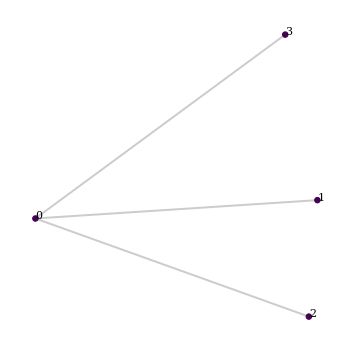

In [5]:
link_sparse_matrix = [  [0,1, 1.0],
                        [0,2, 1.0],
                        [0,3, 1.0]]
simple_graph = undNetwork.from_sparse(link_sparse_matrix)
simple_graph.cMDE(1.0, 0.0, 1000)
netplot.plot_net(simple_graph, labels = ["0", "1", "2", "3"])
print(f"Mean distortion is {cnets.get_distortion():.2f}")

since unconnected nodes do not alter the distortion value, this would be zero even if node 1,2,3 were coincident.

Negative sampling serves this purpose, pushing a random fraction of non connected nodes away from each other

cnets - INFO: starting MDE with eps = 0.100, neg_eps = 0.001, Nsteps = 600
|▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒|99 % (D = 0.0005)K
cnets - INFO: MDE end
cnets - INFO: starting MDE with eps = 0.100, neg_eps = 0.000, Nsteps = 100
|▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒ |98 % (D = 0.0000)= 0.0000)
cnets - INFO: MDE end

Getting graphics..	Done.
Updating scatter..	Done.
Updating lines..	Done.
Mean distortion is 0.00


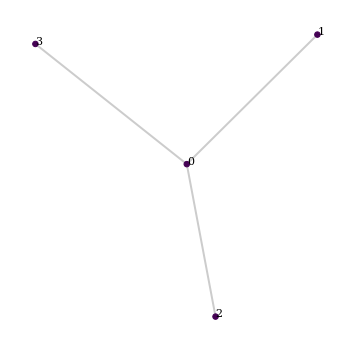

In [6]:
cnets.set_negative_sampling_fraction(1.0) # default is 10%, would be 0 on a three node network
simple_graph.cMDE(0.1, 1e-3, 600) # negative sampling
simple_graph.cMDE(0.1, 0.0, 100)  # final adjustment
netplot.plot_net(simple_graph, labels = ["0", "1", "2", "3"])
print(f"Mean distortion is {cnets.get_distortion():.2f}")

### Representing a knn

This part is dedicated to the representation of a k-nearest-neighbours network from a 4D space to a 2D embedding space.
A knn is best represented by a directed graph (networkMDE.network.dirNetwork).

As an example, generate random points in a 4D space and set their values as their first coordinate. This helps to visualize wether the representation in a lower dimensional space is done in a more or less correct way.
Then generate the knn network, say, of the first 5 neighbours.

In [18]:
points = np.random.uniform(-1,1, size=(500,4))
values = points[:,0]

sparse_matrix = cnets.stupid_knn(points.tolist(), # note: first argument must be a python list
                                5)
print() # somehow jupyter notebooks mess up outputs
net = dirNetwork.from_sparse(sparse_matrix)
net.values = values


cnets - INFO: requested knn with k = 5 of 500 objects in R4
|▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒|99 %K
cnets - INFO: stupid_knn done.
Network has 500 elements and 2492 links (density =  2.0 %)


Now specify the dimension of the embedding space (only 2d and 3d can be represented, obviously) and find the less distortive embedding.

The three cMDE parameters are:
-  *attractive* factor(s)
-  *repulsive* factor(s)
-  *number* of steps(s)

As a rule of thumb, the best performances can be obtained first performing a short repelling run ( 1.0, 0.5, 10) then a longer and less repulsive one (0.5, 0.01, 1000) and then a long nonrepulsive final stage (0.1, 0.0, 3000)

In [19]:
net.initialize_embedding(dim=2)
# note: first argument is a list of attractive factors, the second a list of repulsive ones and third a list of steps
net.cMDE([1.0, 0.5, 0.1], [0.5, 0.01, 0.0], [10, 1000, 3000])

cnets - INFO: Generating network...	Done.
cnets - INFO: Random initialization in R2...	Done.
cnets - INFO: starting MDE with eps = 1.000, neg_eps = 0.500, Nsteps = 10
|▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒     |90 % (D = 2231.2092)2K
cnets - INFO: MDE end
cnets - INFO: starting MDE with eps = 0.500, neg_eps = 0.010, Nsteps = 1000
|▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒��▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒|98 % (D = 114.7508)K114.7803)��▒▒▒▒▒▒▒                            |52 % (D = 114.8291)
cnets - INFO: MDE end
cnets - INFO: starting MDE with eps = 0.100, neg_eps = 0.000, Nsteps = 3000
|▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒|99 % (D = 0.0299)2K
cnets - INFO: MDE end


The final distortion of each run is printed in yellow (D = ...). 

With a low number of neighbours (very local topology) and with an initial space dimension <~= 20 a good distortion is tipically <~ 0.2

Plot the network. If the colors of the nodes display some kind of pattern the knn representation is informative.

Plot started:
Getting graphics..	Done.
Updating scatter..	Done.
Updating lines..	Done.


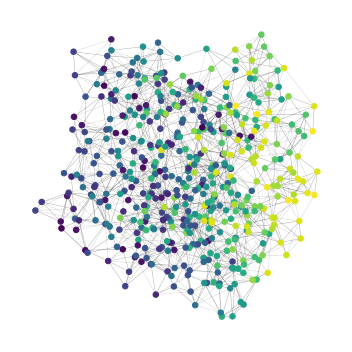

In [20]:
netplot.plot_lines = True # the denser the network, the more time-expensive plotting lines is
netplot.line_kwargs['lw'] = 0.4
netplot.plot_net(net)
plt.show()

To see how much the mean distortion of the netwok is:

In [21]:
cnets.get_distortion()

0.029869267717003822

Note that `cnets` can handle only one network at a time, so after `initialize_embedding` each cnets call refers to the last initialized network.